<a href="https://www.kaggle.com/code/joewraga/heart-failure-prediction-88-f1-score-with-xgboost?scriptVersionId=120322560" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
import itertools
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import sklearn.tree as tree
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


**Task: Predicting mortality from heart failure using 12 feature variables.**

# Data exploration #

In [2]:
df = pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [4]:
df['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


In [6]:
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [7]:
display(df.dtypes)

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

So, 
* There are no missing values 
* 299 total entries. Death was the result in 96 of these instances. 
* 5 categorical and 7 numerical features
* Categorical features already encoded
* Does not appear to be any numerical values with accidental zeros.

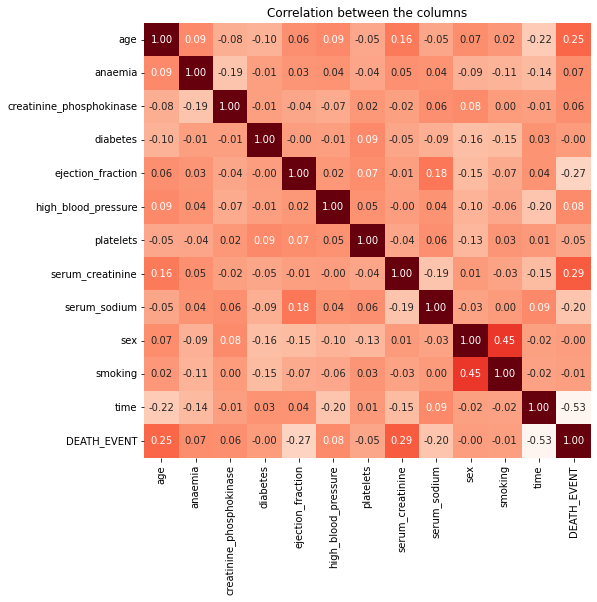

In [8]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot=True, cbar=False, cmap='Reds', fmt='.2f')
plt.title("Correlation between the columns")
plt.show()

So, there are no collinearity issues here.

<AxesSubplot:>

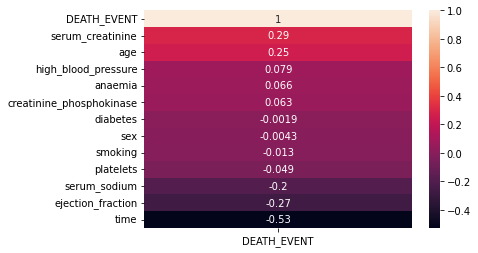

In [9]:
corr = df.corr()[['DEATH_EVENT']].sort_values(by='DEATH_EVENT', ascending=False)
sns.heatmap(corr, annot=True)

It appears time, ejection_fraction, serum_creatinine, and age are the most important features.

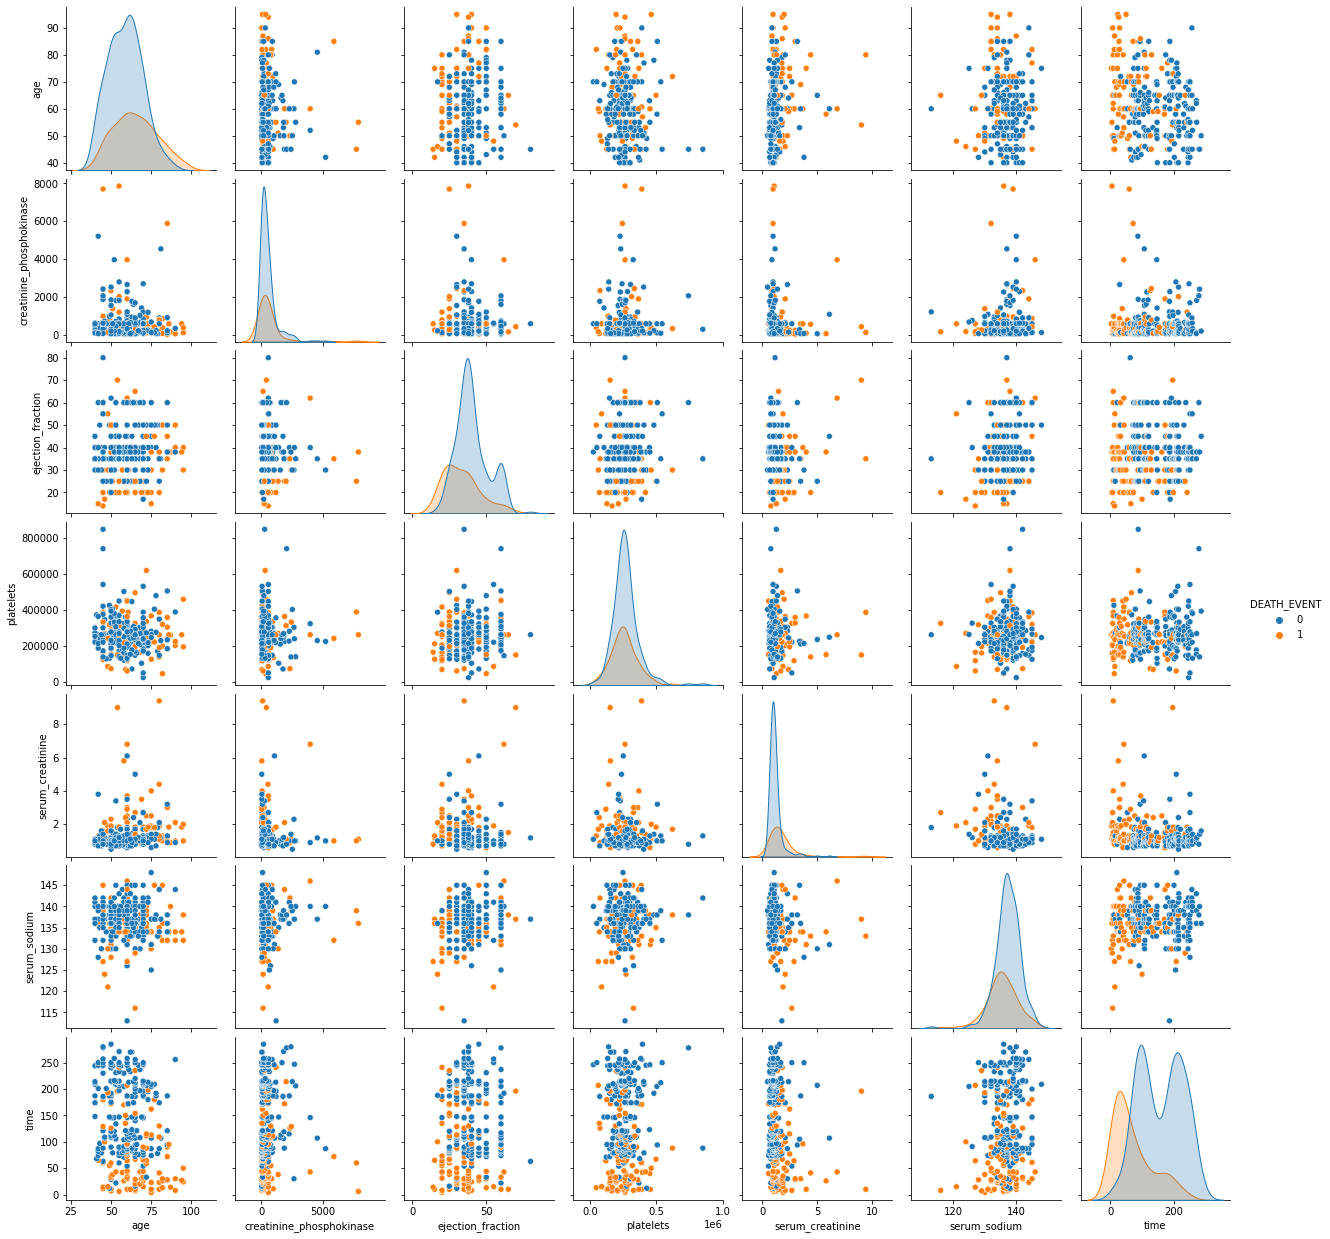

In [10]:
sns.pairplot(df[['age', 'creatinine_phosphokinase',
       'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium','time',
       'DEATH_EVENT']], hue="DEATH_EVENT")

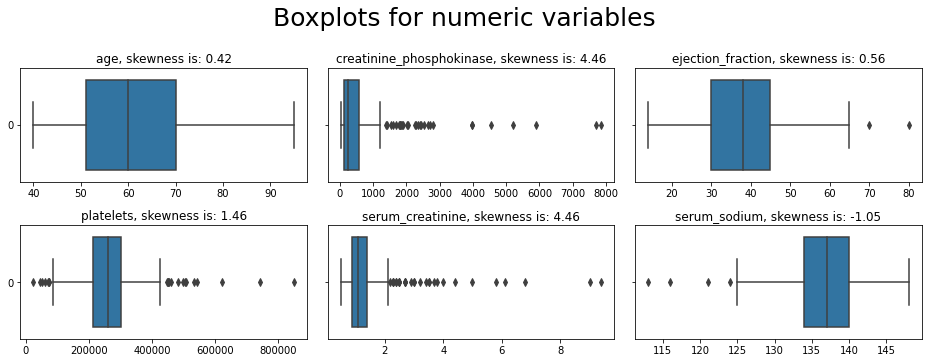

In [11]:
# From https://www.kaggle.com/code/marcinrutecki/voting-classifier-for-better-results
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(13,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
numerical_columns = list(df.loc[:,['age','creatinine_phosphokinase','ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium' ]])
                        
boxplots_custom(dataset=df, columns_list=numerical_columns, rows=2, cols=3, suptitle='Boxplots for numeric variables')
plt.tight_layout()


So, age is fairly normal, and ejection_fraction close. Rest are very skewed.

Will some feature engineering to help this in the model building phase? I will make a copy to compare.

In [12]:
creatinine_log = np.log(df['creatinine_phosphokinase'])
platelets_log = np.log(df['platelets'])
serum_cr_log = np.log(df['serum_creatinine'])
serum_so_log = np.log(df['serum_sodium'])

serum_so_square = df['serum_sodium']**2
platelets_sqrt = df['platelets']**.5


print('Skewness, creatinine Log vs Original:',creatinine_log.skew(),df['creatinine_phosphokinase'].skew())
print('Skewness, platelets Log vs Original:',platelets_log.skew(),df['platelets'].skew())
print('Skewness, serum_creatinine Log vs Original:',serum_cr_log.skew(),df['serum_creatinine'].skew())
print('Skewness, serum_sodium Log vs Original:',serum_so_log.skew(),df['serum_sodium'].skew())
print('---------------')

print('Skewness, serum_sodium Square vs Original:',serum_so_square.skew(),df['serum_sodium'].skew())

print('---------')
print('Skewness, platelets Sqrt vs Original:',platelets_sqrt.skew(),df['platelets'].skew())




Skewness, creatinine Log vs Original: 0.41400698865657504 4.463110084653752
Skewness, platelets Log vs Original: -1.284953956348551 1.4623208382757793
Skewness, serum_creatinine Log vs Original: 1.583989782127556 4.455995882049026
Skewness, serum_sodium Log vs Original: -1.3122653778551319 -1.0481360160574988
---------------
Skewness, serum_sodium Square vs Original: -0.8111746793951639 -1.0481360160574988
---------
Skewness, platelets Sqrt vs Original: 0.17868001456234672 1.4623208382757793


In [13]:
#Original df and transformed one, to compare
df_trans = df.copy()
df_trans.drop(['creatinine_phosphokinase','platelets','serum_creatinine','serum_sodium'],axis=1,inplace=True)
df_trans=pd.concat([df_trans,creatinine_log],axis=1)
#df_trans=pd.concat([df_trans,platelets_log],axis=1)
df_trans=pd.concat([df_trans,platelets_sqrt],axis=1)
df_trans=pd.concat([df_trans,serum_cr_log],axis=1)
df_trans=pd.concat([df_trans,serum_so_square],axis=1)
#df_trans.head()

In [14]:
num_features = ['age', 'creatinine_phosphokinase',
       'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium',
               'time'] 
  

X = df.drop(columns='DEATH_EVENT')
y = df['DEATH_EVENT']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [15]:
# Transformed variables
X_trans = df_trans.drop(columns='DEATH_EVENT')
y_trans = df_trans['DEATH_EVENT']
X_train_trans, X_test_trans, Y_train_trans, Y_test_trans = train_test_split(X_trans, y_trans, test_size=0.3, random_state=4)

In [16]:
# Standardize
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()
# apply standardization on numerical features only
for i in num_features:
    # Fit transformation on Training data
    scale = StandardScaler().fit(X_train_stand[[i]])
    # Now apply to Training and Test data
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

In [17]:
# Standardize Transformed variables
X_train_stand_trans = X_train_trans.copy()
X_test_stand_trans = X_test_trans.copy()
# apply standardization on numerical features only
for i in num_features:
    # Fit transformation on Training data
    scale = StandardScaler().fit(X_train_stand_trans[[i]])
    # Now apply to Training and Test data
    X_train_stand_trans[i] = scale.transform(X_train_stand_trans[[i]])
    X_test_stand_trans[i] = scale.transform(X_test_stand_trans[[i]])

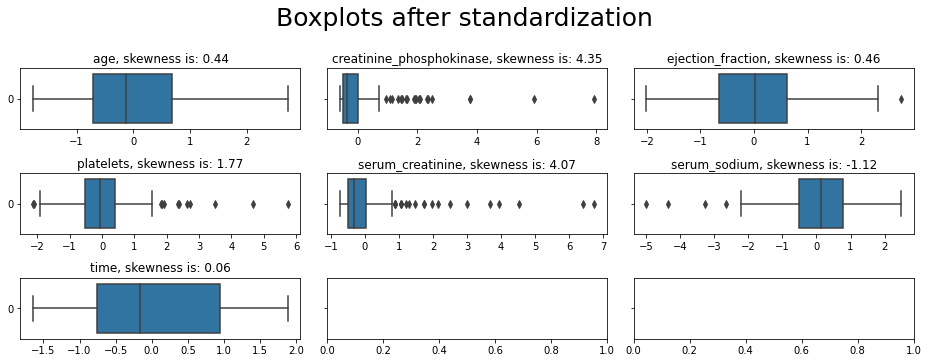

In [18]:

numerical_columns = list(X_train_stand.loc[:,['age','creatinine_phosphokinase','ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium','time' ]])             
boxplots_custom(dataset=X_train_stand, columns_list=numerical_columns, rows=3, cols=3, suptitle='Boxplots after standardization')
plt.tight_layout()

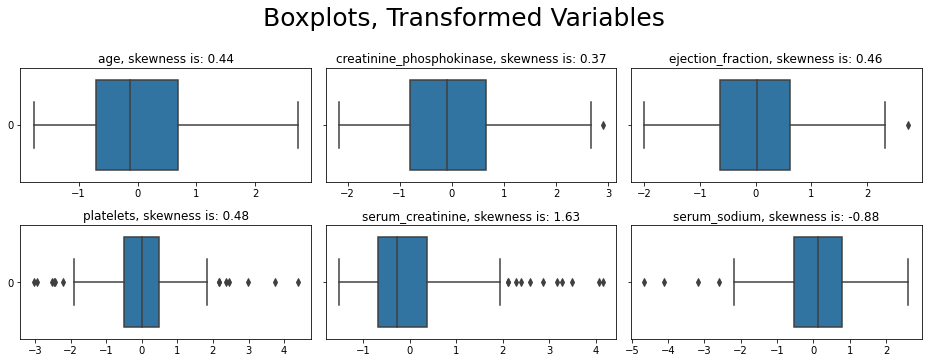

In [19]:
numerical_columns = list(X_train_stand_trans.loc[:,['age','creatinine_phosphokinase','ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium' ]])             
boxplots_custom(dataset=X_train_stand_trans, columns_list=numerical_columns, rows=2, cols=3, suptitle='Boxplots, Transformed Variables')
plt.tight_layout()

<AxesSubplot:xlabel='serum_sodium', ylabel='Count'>

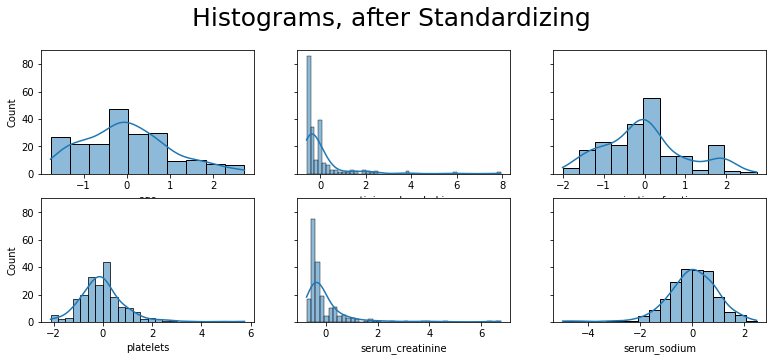

In [20]:
# Histograms of Standardized Train data 
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(13,5))
fig.suptitle('Histograms, after Standardizing',y=1, size=25)
axs = axs.flatten()
sns.histplot(X_train_stand['age'],kde=True,ax=axs[0])
sns.histplot(X_train_stand['creatinine_phosphokinase'],kde=True,ax=axs[1])
sns.histplot(X_train_stand['ejection_fraction'],kde=True,ax=axs[2])
sns.histplot(X_train_stand['platelets'],kde=True,ax=axs[3])
sns.histplot(X_train_stand['serum_creatinine'],kde=True,ax=axs[4])
sns.histplot(X_train_stand['serum_sodium'],kde=True,ax=axs[5])

In [21]:
# From https://www.kaggle.com/code/benjivdm/determining-the-best-ml-model-for-spacex
def plot_confusion_matrix(y,y_predict):
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['No death event', 'Death event']); ax.yaxis.set_ticklabels(['No death event', 'Death event'])
    plt.show()

Function to perform Grid Search for hyperparameter tuning, optimizing for f1 score. Outputs confusion matrix and ROC curve.

In [22]:
def Grid_and_eval(classifier,params,cv=10):
    parameters = params
    model_cv = GridSearchCV(classifier,parameters,cv=cv,scoring='f1',verbose=0)
    model_cv.fit(X_train_stand,Y_train) 
    print("Tuned hyperparameters: ",model_cv.best_params_)
    print("Mean CV f1_score of best_estimator, on Training:",model_cv.best_score_)
    best_model = model_cv.best_estimator_
    print("Best estimator:",best_model)
    print("f1 on Test data (Positive case only):",model_cv.score(X_test_stand,Y_test))
    print("f1 on Train data:",model_cv.score(X_train_stand,Y_train))

    yhat=model_cv.predict(X_test_stand)   #Using the best found params 

    print("Classification report:") 
    print(classification_report(Y_test,yhat))#,output_dict=True)) 
    plot_confusion_matrix(Y_test,yhat)
    
    precision, recall, f1_res, _ = precision_recall_fscore_support(Y_test,yhat,average='weighted')
    
    ######## ROC curve ############
    y_pred_proba = model_cv.predict_proba(X_test_stand)[::,1]
    fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.legend(loc=4)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()
    return [f1_res,auc,precision,recall]

Same, but writing separate function for the transformed dataframe.

In [23]:
def Grid_and_eval_trans(classifier,params,cv=10):
    parameters = params
    model_cv = GridSearchCV(classifier,parameters,cv=cv,scoring='f1',verbose=0)
    model_cv.fit(X_train_stand_trans,Y_train_trans) 
    print("Tuned hyperparameters: ",model_cv.best_params_)
    print("Mean CV f1_score of best_estimator, on Training:",model_cv.best_score_)
    best_model = model_cv.best_estimator_
    print("Best estimator:",best_model)

    print("f1 on Test data (Positive case only):",model_cv.score(X_test_stand_trans,Y_test_trans))
    print("f1 on Train data:",model_cv.score(X_train_stand_trans,Y_train_trans))

    yhat=model_cv.predict(X_test_stand_trans) #Using the best found params 
    
    print("Classification report:") 
    print(classification_report(Y_test_trans,yhat))#,output_dict=True)) 
    plot_confusion_matrix(Y_test_trans,yhat)
    
    precision, recall, f1_res, _ = precision_recall_fscore_support(Y_test_trans,yhat,average='weighted')
    
    # ROC curve
    y_pred_proba = model_cv.predict_proba(X_test_stand_trans)[::,1]
    fpr, tpr, _ = metrics.roc_curve(Y_test_trans,  y_pred_proba)
    auc = metrics.roc_auc_score(Y_test_trans, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.legend(loc=4)
    plt.title('Receiver Operating Characteristic')
    plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()
    plt.show()
    return [f1_res,auc,precision,recall]
    

In [24]:
model = []
f1_results = [] # weighted avg
auc_results = []
precision_results = []
recall_results = []

model_trans = []
f1_results_trans = [] # weighted avg
auc_results_trans = []
precision_results_trans = []
recall_results_trans = []

**Model Building**

**1) Logistic Regression**

Tuned hyperparameters:  {'C': 0.3, 'penalty': 'l2', 'solver': 'liblinear'}
Mean CV f1_score of best_estimator, on Training: 0.695845004668534
Best estimator: LogisticRegression(C=0.3, solver='liblinear')
f1 on Test data (Positive case only): 0.7346938775510204
f1 on Train data: 0.7518796992481204
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        66
           1       0.72      0.75      0.73        24

    accuracy                           0.86        90
   macro avg       0.81      0.82      0.82        90
weighted avg       0.86      0.86      0.86        90



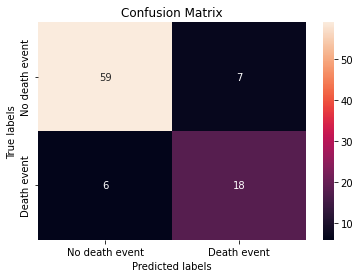

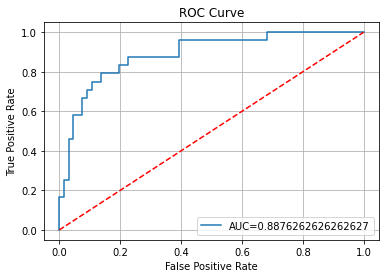

In [25]:
result = Grid_and_eval(LogisticRegression(),params ={'C':[.3,.4,.5],
                                            'penalty':['l2'],
                                            'solver':['lbfgs', 'liblinear', 'newton-cg']}#['liblinear', 'newton-cg']}
             ) 

In [26]:
f1_results.append(result[0])
auc_results.append(result[1])
precision_results.append(result[2])
recall_results.append(result[3])
model.append('Logistic Regression')

Tuned hyperparameters:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Mean CV f1_score of best_estimator, on Training: 0.7061721611721612
Best estimator: LogisticRegression(C=0.1, solver='liblinear')
f1 on Test data (Positive case only): 0.7450980392156864
f1 on Train data: 0.7407407407407406
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        66
           1       0.70      0.79      0.75        24

    accuracy                           0.86        90
   macro avg       0.81      0.84      0.82        90
weighted avg       0.86      0.86      0.86        90



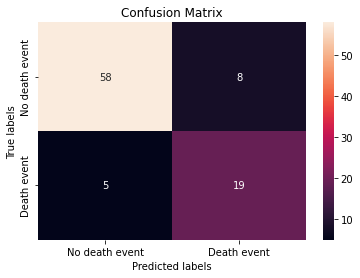

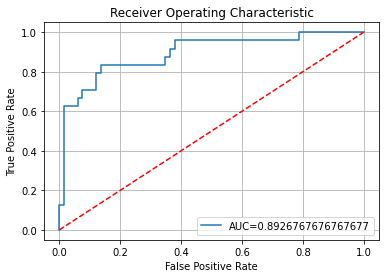

In [27]:
result = Grid_and_eval_trans(LogisticRegression(),params ={'C':[0.001,0.01,0.1,1],
                                                  'penalty':['l2'],
                                                  'solver':['liblinear', 'newton-cg']}
                   )


In [28]:
f1_results_trans.append(result[0])
auc_results_trans.append(result[1])
precision_results_trans.append(result[2])
recall_results_trans.append(result[3])
model_trans.append('Logistic Regression')

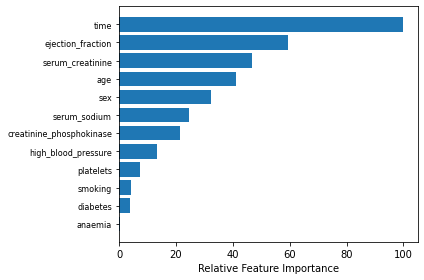

In [29]:
# Feature Importance, on Test set
lr = LogisticRegression(C= 0.3, penalty='l2', solver= 'liblinear')
lr.fit(X_train_stand,Y_train)
feature_importance = abs(lr.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

2) K-Nearest Neighbors

Tuned hyperparameters:  {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 5, 'p': 4, 'weights': 'uniform'}
Mean CV f1_score of best_estimator, on Training: 0.6680619380619381
Best estimator: KNeighborsClassifier(leaf_size=1, p=4)
f1 on Test data (Positive case only): 0.5499999999999999
f1 on Train data: 0.7424242424242424
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        66
           1       0.69      0.46      0.55        24

    accuracy                           0.80        90
   macro avg       0.76      0.69      0.71        90
weighted avg       0.79      0.80      0.79        90



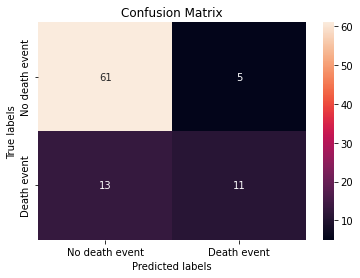

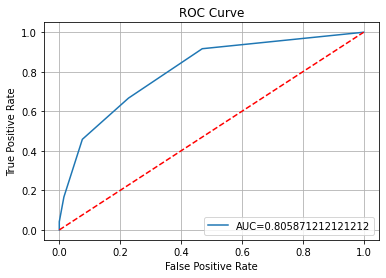

In [30]:
result = Grid_and_eval(KNeighborsClassifier(),{'n_neighbors': [4,5,6,7],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [3,4,5,6],'leaf_size':[1,3,5,10],'weights':['uniform','distance']
                                     })

In [31]:
f1_results.append(result[0])
auc_results.append(result[1])
precision_results.append(result[2])
recall_results.append(result[3])
model.append('KNN')

Tuned hyperparameters:  {'algorithm': 'auto', 'n_neighbors': 9, 'p': 2}
Mean CV f1_score of best_estimator, on Training: 0.6122710622710622
Best estimator: KNeighborsClassifier(n_neighbors=9)
f1 on Test data (Positive case only): 0.5789473684210527
f1 on Train data: 0.638655462184874
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        66
           1       0.79      0.46      0.58        24

    accuracy                           0.82        90
   macro avg       0.81      0.71      0.73        90
weighted avg       0.82      0.82      0.81        90



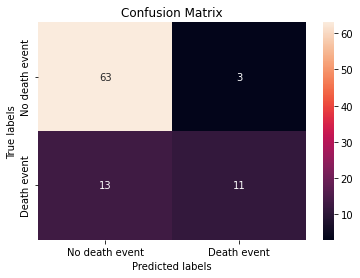

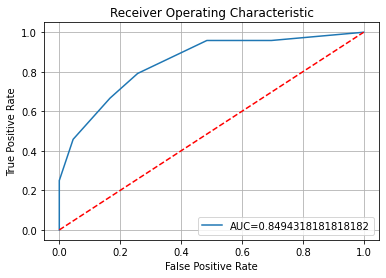

In [32]:
result = Grid_and_eval_trans(KNeighborsClassifier(),{'n_neighbors': [6,7,8, 9,10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2,3]})


In [33]:
f1_results_trans.append(result[0])
auc_results_trans.append(result[1])
precision_results_trans.append(result[2])
recall_results_trans.append(result[3])
model_trans.append('KNN')

3) Support Vector Machine

Tuned hyperparameters:  {'C': 70, 'gamma': 0.001, 'kernel': 'rbf'}
Mean CV f1_score of best_estimator, on Training: 0.6862601450836745
Best estimator: SVC(C=70, gamma=0.001, probability=True)
f1 on Test data (Positive case only): 0.7346938775510204
f1 on Train data: 0.7313432835820894
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        66
           1       0.72      0.75      0.73        24

    accuracy                           0.86        90
   macro avg       0.81      0.82      0.82        90
weighted avg       0.86      0.86      0.86        90



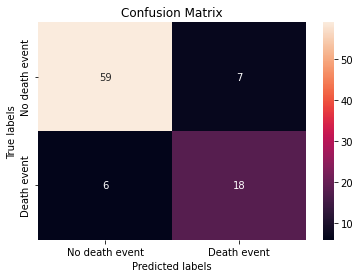

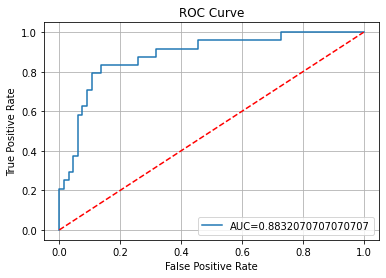

In [34]:
#Grid_and_eval(svm.SVC(probability=True),{'kernel':('linear', 'rbf'),#,'poly','rbf', 'sigmoid'),
#              'C': np.logspace(-3, 3, 3)#,
#             # 'gamma':np.logspace(-3, 3, 3)
#                        })

#Above is slow, so I will just show what I narrowed it down to

result = Grid_and_eval(svm.SVC(probability=True),{'kernel':['rbf'],#,'poly','rbf', 'sigmoid'),
              'C': [60,70,80],
           # 'degree':[2,3]
              'gamma':[1e-4,1e-3,1e-2]#np.logspace(-3, 3, 3)
                        })

In [35]:
f1_results.append(result[0])
auc_results.append(result[1])
precision_results.append(result[2])
recall_results.append(result[3])
model.append('SVM')

Tuned hyperparameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Mean CV f1_score of best_estimator, on Training: 0.7102029016734899
Best estimator: SVC(C=100, gamma=0.01, probability=True)
f1 on Test data (Positive case only): 0.6382978723404256
f1 on Train data: 0.8652482269503546
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        66
           1       0.65      0.62      0.64        24

    accuracy                           0.81        90
   macro avg       0.76      0.75      0.76        90
weighted avg       0.81      0.81      0.81        90



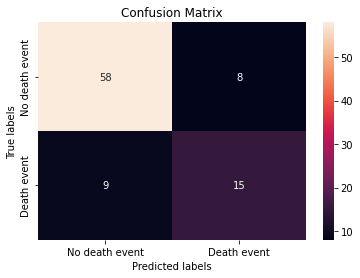

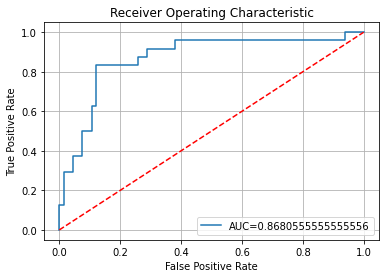

In [36]:
result = Grid_and_eval_trans(svm.SVC(probability=True),{'kernel':('linear', 'rbf'),#,'poly','rbf', 'sigmoid'),
              'C': [50,80,100,120],#np.logspace(-3, 3, 3)#,
             # 'gamma':np.logspace(-3, 3, 3)
               'gamma':[5e-3,1e-2,5e-2]
                        })



In [37]:
f1_results_trans.append(result[0])
auc_results_trans.append(result[1])
precision_results_trans.append(result[2])
recall_results_trans.append(result[3])
model_trans.append('SVM')

4) Random Forest

In [38]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

random_grid = {'n_estimators': [ 2000, 2585, 3000],
#                'max_features': ['auto', 'sqrt'],
               'max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],
               'min_samples_split': [ 2, 5, 10, 20, 30],
               'min_samples_leaf': [ 3, 4],
               'bootstrap': [True, False],
               'criterion': ['gini', 'entropy']}

# Begin search and fit classifier
rf_base = RandomForestClassifier(random_state=0)
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5,
                               verbose=0,
                               random_state=42, n_jobs = 4,
                              scoring = 'f1'
                              )
rf_random.fit(X_train_stand, Y_train)

# View params
print("Best params:",rf_random.best_params_)

#Evaluate   
print (rf_random.score(X_train_stand, Y_train))
print(rf_random.score(X_test_stand, Y_test))

Best params: {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.9130434782608695
0.7555555555555556


In [39]:
# Trying Grid with above
param_grid = {
    'n_estimators': [1800,2000,2200],
    'max_depth': [4,5,6],
    'min_samples_split': [4,5,6],
    'min_samples_leaf': [3,4,5]
}

rf_grid = RandomForestClassifier(criterion = 'gini', bootstrap = False,random_state=0)
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = 8, verbose = 0)
grid_rf_search.fit(X_train_stand, Y_train)


best_rf_grid = grid_rf_search.best_estimator_
print("Best params:",grid_rf_search.best_params_)


print (grid_rf_search.score(X_train_stand, Y_train))
print(grid_rf_search.score(X_test_stand, Y_test))

Best params: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1800}
0.9186602870813397
0.8777777777777778


Tuned hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1500}
Mean CV f1_score of best_estimator, on Training: 0.7882360602360603
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=4,
                       n_estimators=1500, random_state=0)
f1 on Test data (Positive case only): 0.7555555555555556
f1 on Train data: 0.9130434782608695
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        66
           1       0.81      0.71      0.76        24

    accuracy                           0.88        90
   macro avg       0.85      0.82      0.84        90
weighted avg       0.87      0.88      0.88        90



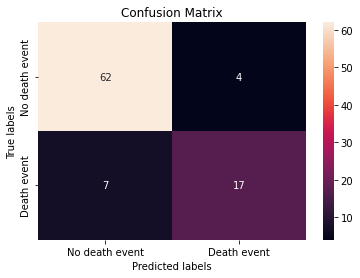

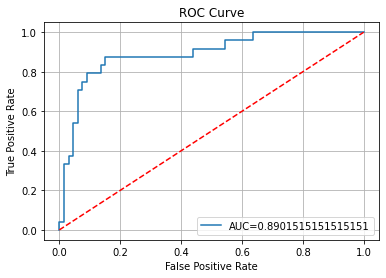

In [40]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

result = Grid_and_eval(RandomForestClassifier(criterion = 'gini', bootstrap = False,random_state=0),{
    'n_estimators': [1500],
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [4]
},cv=5)

In [41]:
f1_results.append(result[0])
auc_results.append(result[1])
precision_results.append(result[2])
recall_results.append(result[3])
model.append('Random Forest')

Tuned hyperparameters:  {'max_depth': 45, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1800}
Mean CV f1_score of best_estimator, on Training: 0.7771380781703362
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=45, min_samples_leaf=5,
                       n_estimators=1800, random_state=0)
f1 on Test data (Positive case only): 0.7391304347826088
f1 on Train data: 0.9444444444444444
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        66
           1       0.77      0.71      0.74        24

    accuracy                           0.87        90
   macro avg       0.83      0.82      0.82        90
weighted avg       0.86      0.87      0.86        90



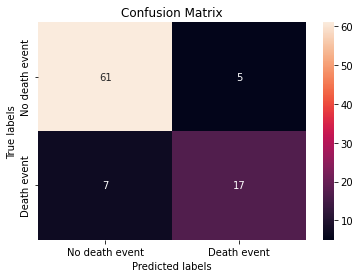

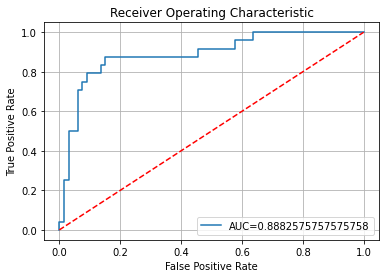

In [42]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
result = Grid_and_eval_trans(RandomForestClassifier(criterion = 'gini', bootstrap = False,random_state=0),{
    'n_estimators': [1600,1800],
    'max_depth': [45,55,65],
    'min_samples_split': [2,3],
    'min_samples_leaf': [2,3,4,5,6]
},cv=5)

In [43]:
f1_results_trans.append(result[0])
auc_results_trans.append(result[1])
precision_results_trans.append(result[2])
recall_results_trans.append(result[3])
model_trans.append('Random Forest')

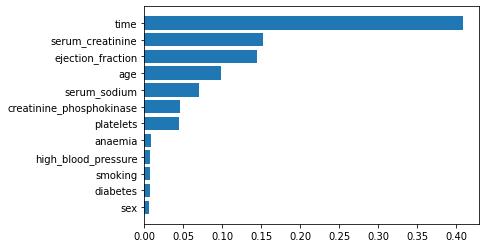

In [44]:

rf = RandomForestClassifier(max_depth=45,min_samples_leaf=5, min_samples_split=2,n_estimators= 1800)
rf.fit(X_train_stand, Y_train)
importance = rf.feature_importances_
indices = np.argsort(importance)
fig, ax = plt.subplots()
ax.barh(range(len(importance)), importance[indices])
ax.set_yticks(range(len(importance)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

5) XGBoost

Fitting 5 folds for each of 15 candidates, totalling 75 fits
tuned hpyerparameters :(best parameters)  {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1}
Mean CV f1_score of best_estimator, on Training : 0.7689469781238414
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)
f1 on Test data (Positive case only): 0.7346938775510204
f1 on T

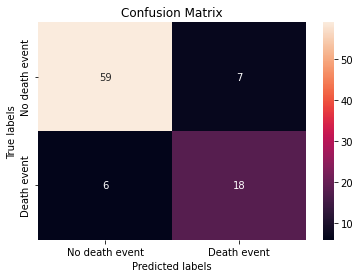

In [45]:
# Random Search

from xgboost import XGBClassifier
param_grid = {'max_depth': [2,4,6,8],
              'learning_rate': [0.01, 0.1, 0.2],
           #   'subsample': np.arange(0.5, 1.0, 0.1),
           #   'colsample_bytree': np.arange(0.5, 1.0, 0.1),
           #   'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
              'n_estimators': [70,100]
              }


estimator = XGBClassifier(objective= 'binary:logistic',nthread=4)
random_search = RandomizedSearchCV(estimator=estimator, 
                           param_distributions=param_grid, 
                           n_iter=15,
                           scoring='f1', 
                           refit='f1', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=1)

random_search.fit(X_train_stand, Y_train)
print("tuned hpyerparameters :(best parameters) ",random_search.best_params_)
print("Mean CV f1_score of best_estimator, on Training :",random_search.best_score_)
best_model = random_search.best_estimator_
print("Best estimator:",best_model)
print("f1 on Test data (Positive case only):",random_search.score(X_test_stand,Y_test))
print("f1 on Train data:",random_search.score(X_train_stand,Y_train))
yhat = random_search.predict(X_test_stand)

print("Classification report:") 
print(classification_report(Y_test,yhat))#,output_dict=True)) 
plot_confusion_matrix(Y_test,yhat)

Tuned hyperparameters:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60}
Mean CV f1_score of best_estimator, on Training: 0.7768448027068716
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=60, n_jobs=4,
              nthread=4, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)
f1 on Test data (Positive case only): 0.75
f1 on Train data: 0.8905109489051095
Classification report:
              precision    recall  f1-score

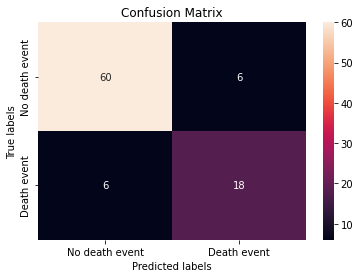

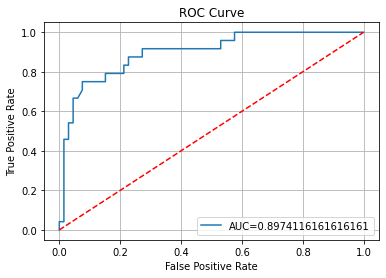

[0.8666666666666667,
 0.8974116161616161,
 0.8666666666666667,
 0.8666666666666667]

In [46]:
Grid_and_eval(XGBClassifier(objective= 'binary:logistic',nthread=4),{
    'max_depth': [2,4,6],
    'n_estimators': [60,70,80],
    'learning_rate': [0.1, 0.01, 0.05]
}
              ,cv=5)

Tuned hyperparameters:  {'eta': 0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'max_leaves': 0, 'min_child_weight': 0.55, 'n_estimators': 50, 'tree_method': 'approx'}
Mean CV f1_score of best_estimator, on Training: 0.7818992289569502
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0,
              min_child_weight=0.55, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=0, ...)
f1 on Test data (Positive case only): 0.7659574468085107
f1

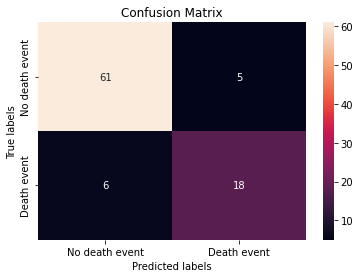

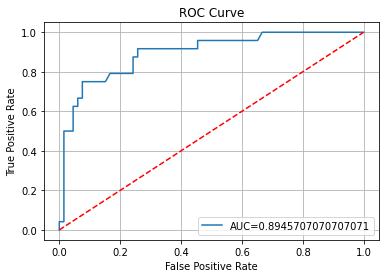

In [47]:
result = Grid_and_eval(XGBClassifier(objective= 'binary:logistic',nthread=4),{
    'max_depth': [2,4,6],
    'n_estimators': [50],
    'learning_rate': [0.1],
    'min_child_weight':[.55],
    'gamma':[0],
    'eta':[0],
    'tree_method':['auto','exact','approx'],
    'max_leaves':[0,1,2]
},cv=5)

In [48]:
f1_results.append(result[0])
auc_results.append(result[1])
precision_results.append(result[2])
recall_results.append(result[3])
model.append('XGBoost')    

Tuned hyperparameters:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 0.55, 'n_estimators': 50}
Mean CV f1_score of best_estimator, on Training: 0.7813881659458871
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0,
              min_child_weight=0.55, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, ...)
f1 on Test data (Positive case only): 0.7659574468085107
f1 on Train data: 0.874074074074074
Classificati

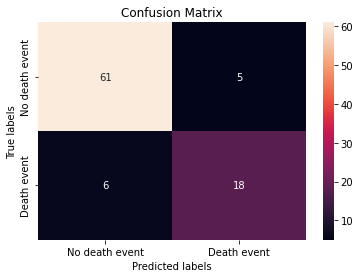

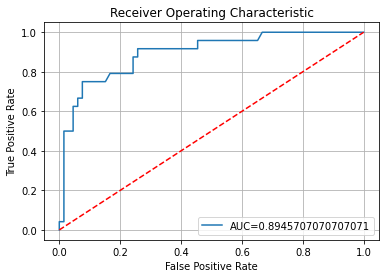

In [49]:
result = Grid_and_eval_trans(XGBClassifier(objective= 'binary:logistic',nthread=4),{
    'max_depth': [2,4],
    'n_estimators': [50],
    'learning_rate': [0.1],
    'min_child_weight':[.45,.55,.65],
    'gamma':[0]
},cv=5)

In [50]:
f1_results_trans.append(result[0])
auc_results_trans.append(result[1])
precision_results_trans.append(result[2])
recall_results_trans.append(result[3])
model_trans.append('XGBoost')

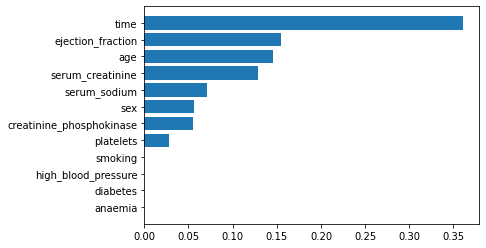

In [51]:
xgb = XGBClassifier(objective= 'binary:logistic',nthread=4,gamma=0,
                    learning_rate=0.1, max_depth=2,
                    min_child_weight=0.55, n_estimators=50)
xgb.fit(X_train_stand, Y_train)
importance = xgb.feature_importances_
indices = np.argsort(importance)
fig, ax = plt.subplots()
ax.barh(range(len(importance)), importance[indices])
ax.set_yticks(range(len(importance)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])


f1 for transformed: [0.8581243350053201, 0.8050901902643933, 0.809811763451181, 0.8647631408176508, 0.8769370234095877]
f1 for untransformed case: [0.856478163784598, 0.7857142857142857, 0.856478163784598, 0.8750617283950618, 0.8769370234095877]


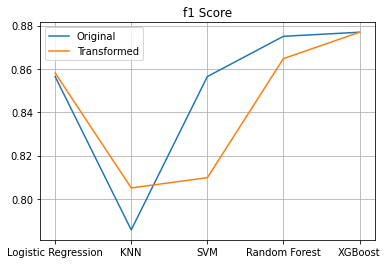

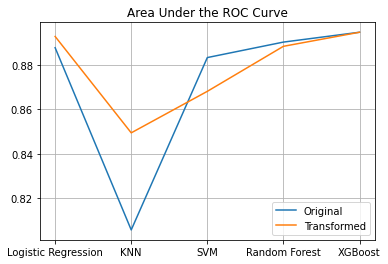

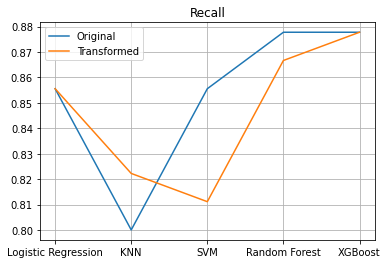

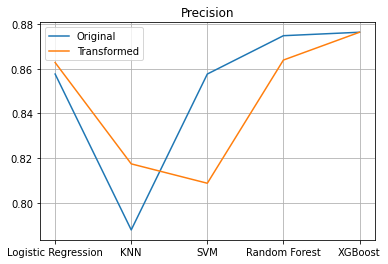

In [52]:
print("f1 for transformed:",f1_results_trans)
print("f1 for untransformed case:",f1_results)
plt.figure()
plt.plot(model,f1_results,label='Original')
plt.plot(model_trans,f1_results_trans,label='Transformed')
plt.legend()
plt.title('f1 Score')
plt.grid(True)

plt.figure()
plt.plot(model,auc_results,label='Original')
plt.plot(model_trans,auc_results_trans,label='Transformed')
plt.legend()
plt.title('Area Under the ROC Curve')
plt.grid(True)

plt.figure()
plt.plot(model,recall_results,label='Original')
plt.plot(model_trans,recall_results_trans,label='Transformed')
plt.legend()
plt.title('Recall')
plt.grid(True)

plt.figure()
plt.plot(model,precision_results,label='Original')
plt.plot(model_trans,precision_results_trans,label='Transformed')
plt.legend()
plt.title('Precision')
plt.grid(True)

# Conclusions #

* XGBoost gives the highest f1, recall, precision, and AUC
* Feature engineering had an effect on some models (mostly SVM and KNN), but not for XGBoost
* Important features: time, ejection_fraction,  serum_creatinine, age. Consistent with heatmap.
* Time is most important: It's good to get diagnosed early